# Extracting 21-cm Global Dark Age Signal From Simulated Signal
#### David W. Barker

## Purpose:
The purpose of this notebook is to see if Pylinex can extract the cosmic Dark Age signal from a very oversimplified model of the beam weighted foreground + beam weighted signal.  This is the first step on the road to a full LuCEE-Night simulation.

The image below is pretty useful for remembering the frequency range we care about. Image is from Chitta Ranjan Das' ICPPA-2024 talk (International Conference on Particle Physics and Astrophysics)


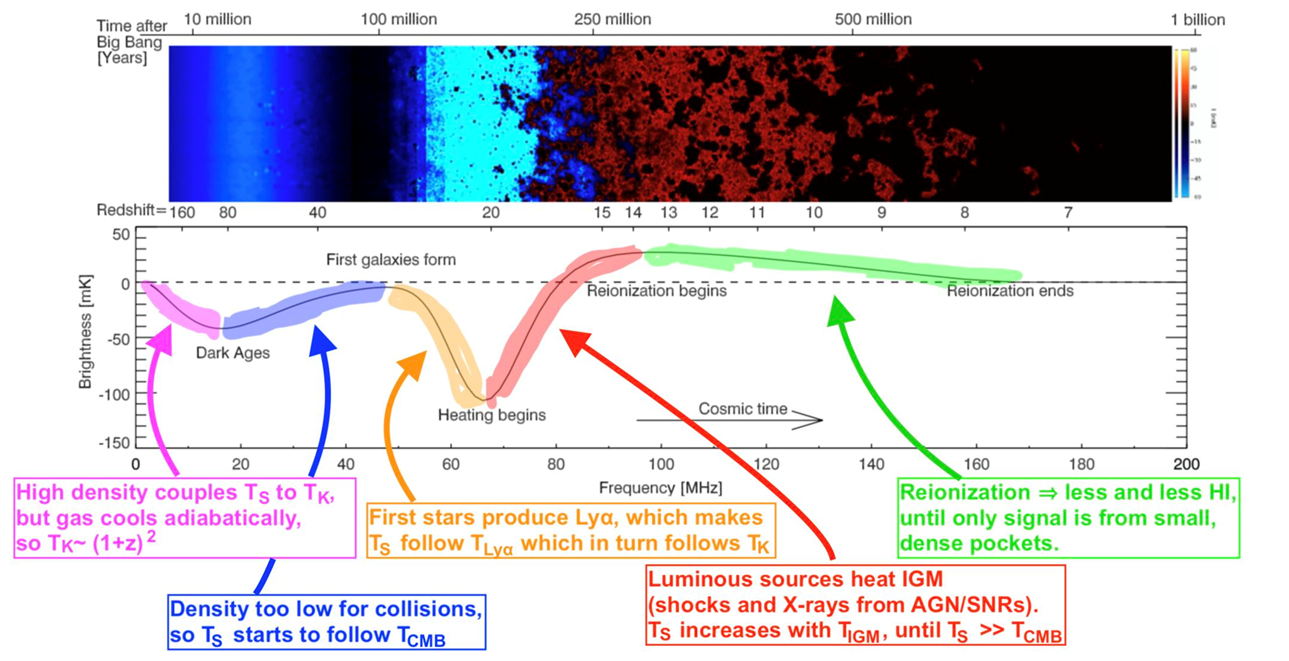

## Beam-weighted Foreground Model:

Let's start with the beam-weighted foreground model.  The beam-weighting, I believe, is as simple as using some function of incident angle of the signal you're recieving and weighting that to the actual simulated signal.  Should look something like this:

$\int_{0}^{\pi}\int_{0}^{2\pi}F(\theta, \nu)B(\theta,\nu)d\theta d\phi$

Where F is your foreground signal and B is your beam weighting. This is the total sky signal for a specific frequency.  Ideally, we would want to graph this as a function of frequency to get our signal, but it depends on where we are pointing our telescope, since the galactic center is not the same as the empty sky.  Our first step is understanding how PERSES deals with this spatial variation.  Is it based on pixels for a total sky map, or do we have to make the conversion ourselves, for example.  Also, does it give you a chance to define the center point that you're pointing at.  I feel like that has to be important if I'm understanding this beam weighting thing at all.  Let's load in a boiler plate and play around with PERSES.

In [2]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
import py21cmfast as p21c
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses

### Making a Frequency Dependent Gaussian Beam

In [3]:
# Using the perses.beam.BaseGaussianBeam._GaussianBeam

num_spatial_data_points = 1000  # specifies the number of data points for the thetas and phis.
num_frequency_data_points = 10  # specifies the number of data points for frequency
# frequency
frequency_start = 5
frequency_end = 40
frequency_increment = np.abs((frequency_start-frequency_end)/num_frequency_data_points)
frequencies = np.arange(frequency_start,frequency_end,frequency_increment)  # frequency in Mhz
# theta
theta_start = 0
theta_end = np.pi
theta_increment = np.abs((theta_start-theta_end)/num_spatial_data_points)
thetas = np.arange(theta_start,theta_end,theta_increment)
# phi
phi_start = 0
phi_end = 2*np.pi
phi_increment = np.abs((phi_start-phi_end)/num_spatial_data_points)
phis = np.arange(phi_start,phi_end,phi_increment)


### Using the perses.beam.BaseGaussianBeam._GaussianBeam ###


GaussianBeam=perses.beam.BaseGaussianBeam._GaussianBeam

# Can adjust whether to use the horizon or not using this property
GaussianBeam.include_horizon=False

# full width half max as a function of frequency x:
GaussianBeam.fwhm = lambda x: (x*1e6)**(1/4)   # right now this is arbitrary and not in any way physical or sensible.  Need to read Joshua's paper to see what he did for the function of the std for the gaussian.
GaussianBeam.initialize_fwhm(GaussianBeam,x_fwhm=GaussianBeam.fwhm) # use this to set the fwhm function

# the cannabalized function taken from perses/perses/beam/BaseGaussianBeam.py gaussian_profile method
fwhms = np.vectorize(GaussianBeam.fwhm)(frequencies)
profile = np.ones((len(frequencies),len(thetas)))
amplitude = 1 # Allows the total gain to be different per frequency (adjusts the gaussian's amplitude [no longer normalized, but that's fine])
for n,x in enumerate(fwhms):   # this is the key difference.  Need to create a 2D array that evaluates each angle at each frequency dependent sigma.
    # this protion is for angular effects of the gaussian distribution
    exponent = thetas * np.ones_like(phis)
    exponent = exponent / np.radians(x)
    exponent = exponent ** 2
    profile_element = amplitude*np.exp(-np.log(16) * exponent)
    if GaussianBeam.include_horizon:
            profile_element = np.where(thetas >= (np.pi / 2), 0, profile_element)
    profile[n] = profile_element

    



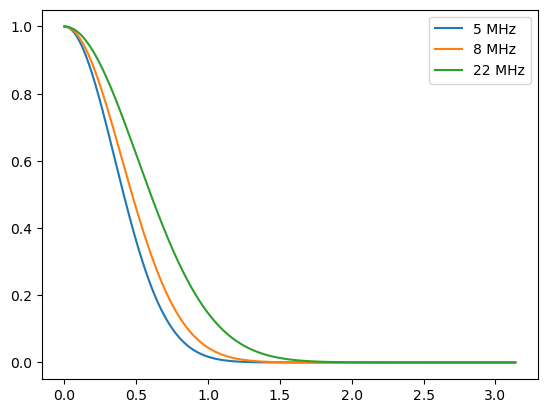

In [4]:
#Plots three different frequency's gaussian profile
plt.plot(thetas,profile[0], label=f'{frequencies[0]:.0f} MHz')
plt.plot(thetas,profile[1], label=f'{frequencies[1]:.0f} MHz')
plt.plot(thetas,profile[5], label=f'{frequencies[5]:.0f} MHz')
plt.legend()

Text(0, 0.5, 'FWHM (MHz)')

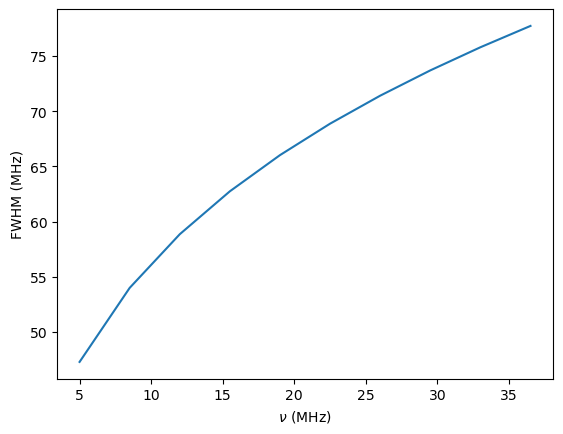

In [5]:
plt.plot(frequencies,GaussianBeam.fwhm(frequencies))
plt.xlabel(r"$\nu$ (MHz)")
plt.ylabel(r"FWHM (MHz)")

Okay, so we have an analytical function, whos functional form can easily change.  That's all well and good, but what we really care about is being able to map that onto the sky so that we can weight each pixel of the foreground using the corresponding pixel based on this function.  This is where healpy comes in.

FWHM as a function of frequency
Also look at residuals potentially

### Mapping A Guassian Beam Onto the Sky Using healpy

https://healpix.jpl.nasa.gov/pdf/intro.pdf  Useful document for understanding healpy.

In [6]:
# boiler plate stuff for healpy
import healpy as hp
from PIL import Image

In [7]:
# Let's make some test set of data that we project onto a sphere. Something really simple:
NSIDE = 128 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)


196608

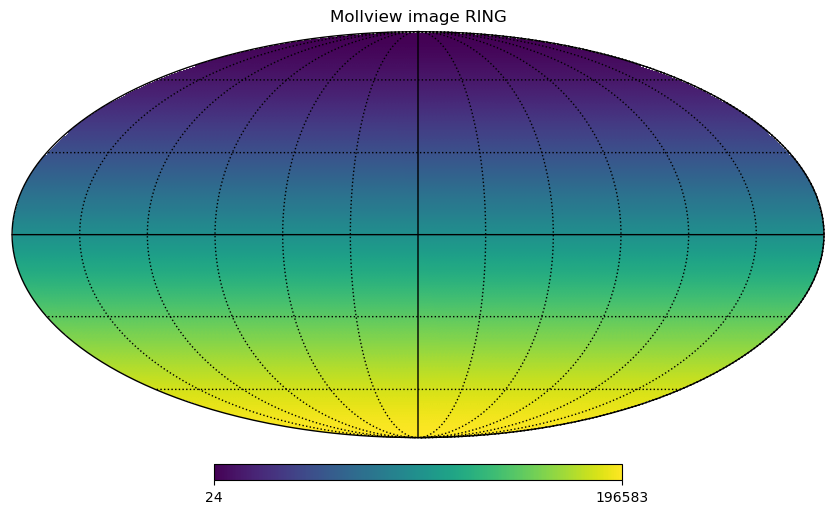

In [8]:
# here is our test projection
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

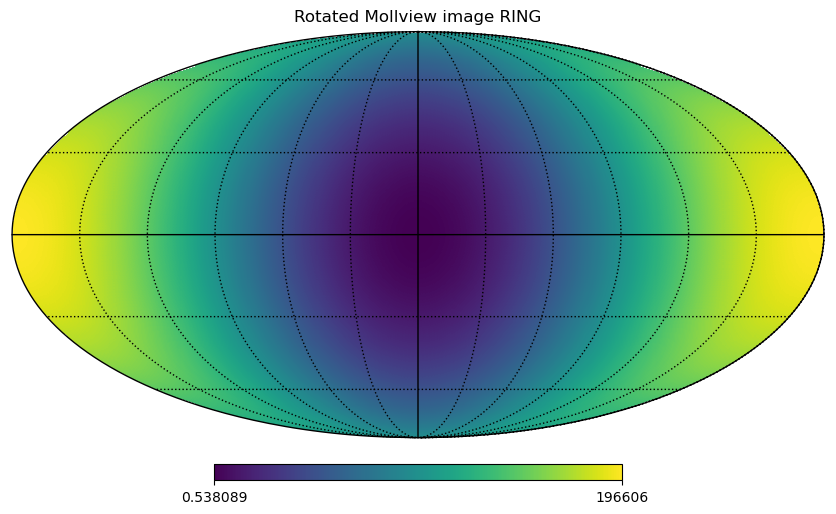

In [9]:
#a key part of this gaussian beam thing is the ability to rotate it to fit the actual set up.
# Let's play with the hp.Rotator method
# convention for the euler angle:
    ### Let's say the equator is the x axis, the meridian the y, and the z axis points out of the screen
    ## First index rotates about the y axis
    ## Second index rotates about the x axis
    ## Third index rotates about the z axis
euler_test_angle = [0,90,0]  # numbers should be in degrees (not radians)
Rotated_test = hp.Rotator(rot=euler_test_angle).rotate_map_pixel(m)  # rotates original map m by angle euler_test_angle
hp.mollview(Rotated_test, title="Rotated Mollview image RING")
hp.graticule()

This is great. It means we can stick to sensible and useful coordinates and then very easily rotate them to new positions in the sky.

Next thing:  Let's actually map that gaussian beam:


In [10]:
# Let's start by converting angles to pixels to make sure we know what's going on with that:
hp.ang2pix(NSIDE,np.pi/2,np.pi*3/4)
# cool, I think we know what it's doing here
# Now let's convert our Gaussian function into a 2D array of theta and phi:
d_theta = theta_increment  # the increment for each index in theta
d_phi = phi_increment     # the increment for each index in phi
d_freq = frequency_increment  # the increment for each index in frequency
# Let's create a 2D array of the profile values from our Gaussian beam we calculated earlier (frequency,theta,phi)
projected_profile = np.zeros((num_frequency_data_points,thetas.shape[0],thetas.shape[0]))

for i in np.arange(num_frequency_data_points):
    for j in np.arange(thetas.shape[0]):
        for k in np.arange(thetas.shape[0]):
            projected_profile[i][j][0:thetas.shape[0]] = profile[i][j] # because it's an axisymmetric gaussian

# now we have our beam weighting as a function of projected spherical position and frequency  


In [ ]:
# Let's now make a function that can convert each point into a pixel number:
# allows us to convert a beam that is a function of angle to a beam as a function of pixel
def ang2pix (data, frequency,healpy_resolution,d_theta,d_phi):
    """data is a 3D array of beam weights for 2D positions for each frequency
    frequency = the specific frequency index you want the pixel array to be referencing (
    can only map one frequency at a time in this case))
    healpy_resolution = the NSIDE resolution your using for the healpy map
    d_theta = theta increment used in creating the data array
    d_phi = phi increment used in creating the data array """
    healpy_map = np.zeros(hp.nside2npix(healpy_resolution))
    old_pixel = 0
    pixel_element_array = np.array([])
    for i in np.arange(data.shape[1]):
        for j in np.arange(data.shape[2]):
            pixel_index=hp.ang2pix(healpy_resolution,i*d_theta,j*d_phi)
            if pixel_index == old_pixel:
                pixel_element_array = np.append(pixel_element_array,data[frequency][i][j])
            else:
                healpy_map[pixel_index-1]=np.average(pixel_element_array)
                old_pixel = pixel_index
                pixel_element_array = np.array([])
                pixel_element_array = np.append(pixel_element_array,data[frequency][i][j])
    return healpy_map

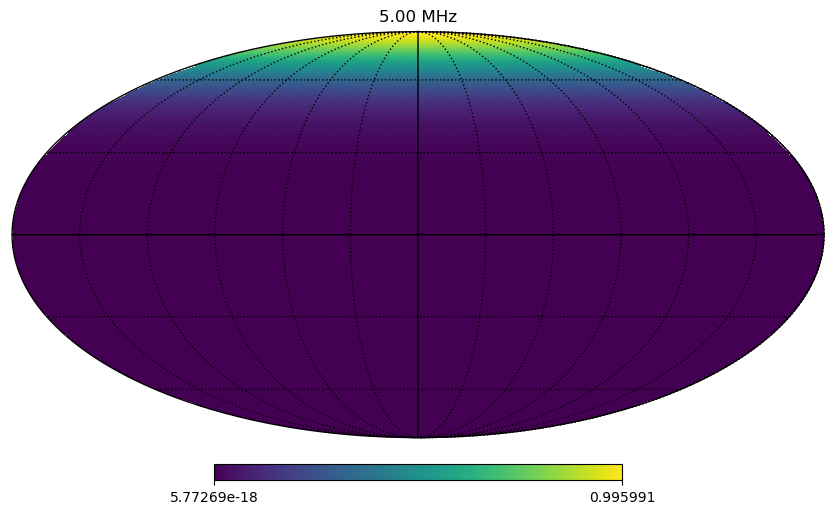

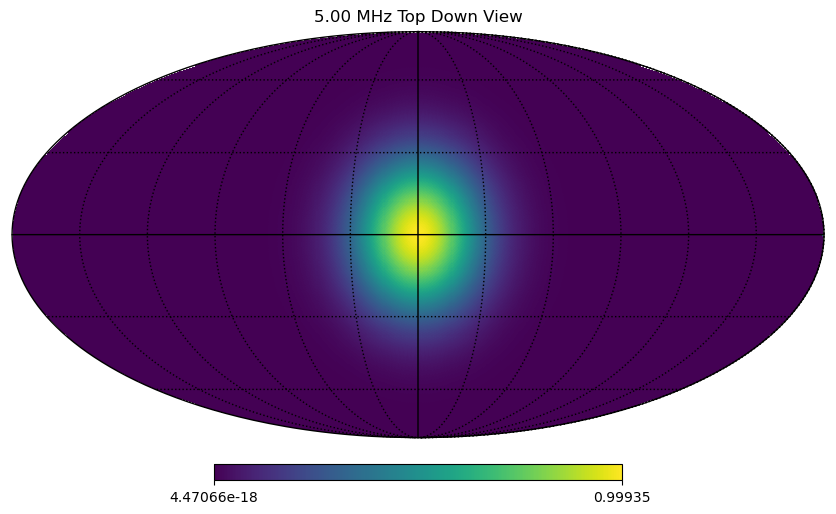

In [12]:
# Let's plug in some numbers for the above function based on our Gaussian:
# NOTE: if it looks funny and kinda like a psychadelic flower, you need a higher spatial resolution 
# in your projected_profile array
frequency_index = 0
frequency_0_map=ang2pix(projected_profile,frequency_index,NSIDE,d_theta,d_phi)
hp.mollview(frequency_0_map, title=f"{(frequency_increment*frequency_index)+frequency_start:.2f} MHz")
hp.graticule()
euler_angle = [0,90,0]  # numbers should be in degrees (not radians)
Rotated = hp.Rotator(rot=euler_angle).rotate_map_pixel(frequency_0_map)  # rotates original map m by angle euler_test_angle
hp.mollview(Rotated, title=f"{(frequency_increment*frequency_index)+frequency_start:.2f} MHz Top Down View")
hp.graticule()

Next step is to use maybe a Haslam map or something of the sort to see if we can actually weight the thing.

In [13]:
# Here is HASLAM, but we need to figure out how to extract the information from it.
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

Prepared Haslam map in 0.128 s.


/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


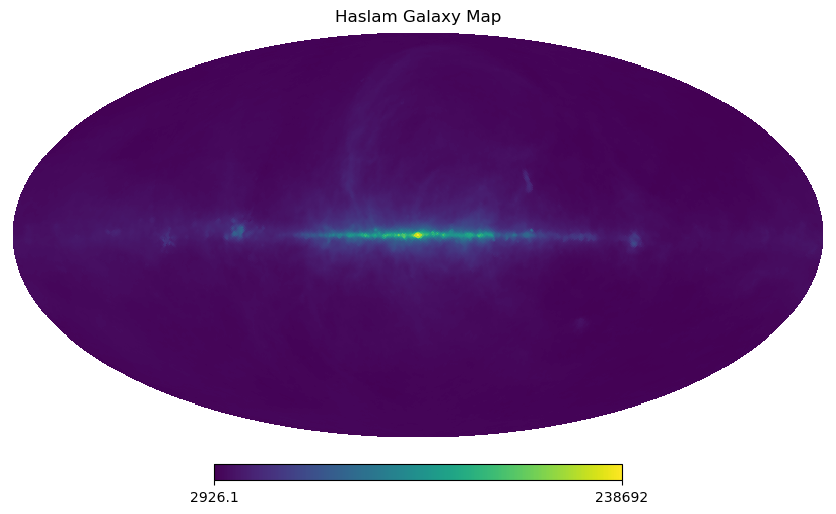

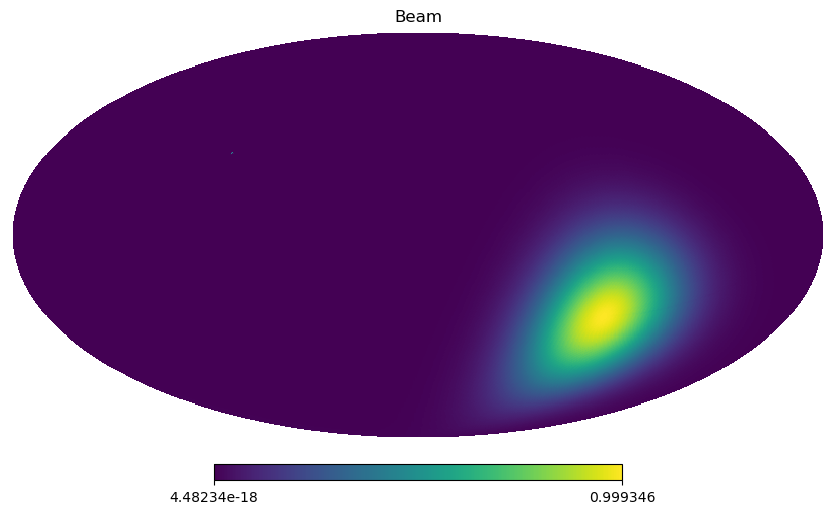

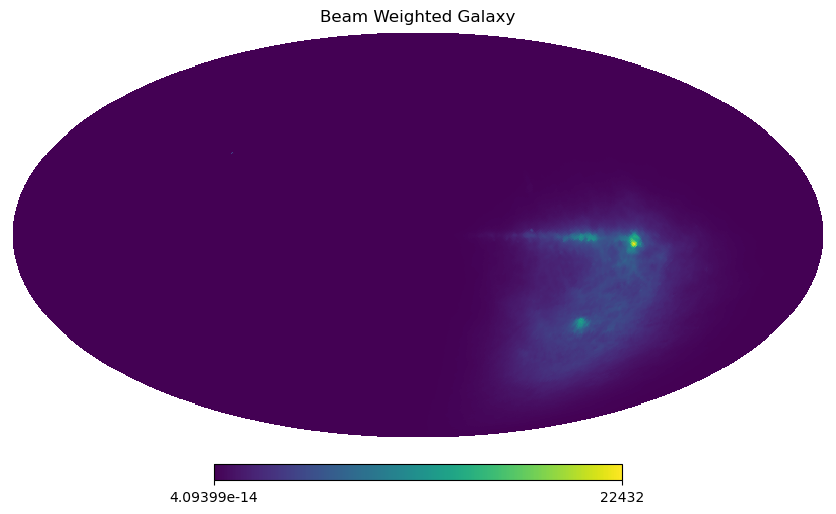

In [14]:
# now let's weight the haslam data with the beam:
hp.mollview(haslam_data,title="Haslam Galaxy Map")
beam_euler_angle = [0,180,60] # this rotates only the beam, not the galaxy
rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(frequency_0_map)
hp.mollview(rotated_beam,title="Beam")
visual_euler_angle = [0,0,0]  # this rotates the total map (galaxy times weighted beam)
rotated_haslam = hp.Rotator(rot=visual_euler_angle).rotate_map_pixel(haslam_data*rotated_beam)  # rotates original map m by angle euler_test_angle
hp.mollview(rotated_haslam, title="Beam Weighted Galaxy")  # weighted galaxy with beam


And this is all really cool, but we need to get some actual data out of this.

In [80]:
# Let's pull out the global signal by adding up all of these pixels and getting an average per pixel count.

def beam_weighted_foreground (frequencies,beam,beam_euler_angle=[0,0,0],euler_angle=[0,0,0]):
    """ Returns an array of all of your healpy maps and beam weighted healpy maps per frequency (instead of just one frequency)

    Parameters
    -------------------------------------
    frequencies:  your array of frequencies in which to evaluate over
    beam:     A 2-D array that is N x Pixel count.  The N is your number of evaluated frequencies and must match the haslam_dat_total shape.  This may take some massaging
              (such as with the ang2pix function if you're converting an analytical function to pixel values).
    euler_angle:  3 element array that is your angle of rotation based on a normal galactic plane. Default is no rotation.
    beam_euler_angle:   3 element array that is your angle of rotation based on a normal galactic plane. Default is no rotation.
                        Keep in mind as you rotate the galaxy, this does not automatically follow in the same location (maybe make that automatic later).  
    
    Returns
    -------------------------------------
    haslam_data_total:   2-D array of haslam pixel map values vs your N frequency values (N x Pixel count matrix)
    weighted_foreground_total:    2-D array of the weighted haslam pixel map values vs your N frequency values (N x Pixel count matrix)
    haslam_global:    1-d array of sky averaged global signal intensity vs frequency (get that from the index)"""
    
    gal = perses.foregrounds.HaslamGalaxy()   # generate the Haslam map model through perses
    haslam_data_total = np.zeros((frequencies.shape[0],NPIX))    # make a blank matrix (helpful for later)
    weighted_foreground_total = np.zeros((frequencies.shape[0],NPIX))
    haslam_global_total = np.array([])    # blank array useful for later
    weighted_global_total = np.array([])   # blank array useful for later

    for n,f in enumerate(frequencies):      # goes through all of our frequencies (one of the parameters of the function)
        haslam_data_element=gal.get_map(f) # grabs the healpy array from the haslam model at that specific frequency
        rotated_haslam_element = hp.Rotator(rot=euler_angle).rotate_map_pixel(haslam_data_element)  # rotates original map m by angle euler_test_angle
        haslam_global=rotated_haslam_element.sum()/rotated_haslam.shape[0] # per frequency global signal
        haslam_data_total[n] = haslam_data_element     # add the iterative value of the haslam data to the master array of all the data
        haslam_global_total = np.append(haslam_global_total,haslam_global)      # add the global signal for this frequency to the graph of the global signal
        # for the beam weighted foreground:
        rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(beam[n])     # rotates the beam to whatever location you want to evaluate it at.
        weighted_foreground_total[n] = rotated_haslam_element*rotated_beam   # add the iterative value of the weighted data to the master array of all the weighted data
        weighted_global = (rotated_haslam_element*rotated_beam).sum()/(rotated_haslam*rotated_beam).shape[0]   # per frequency weighted global signal
        weighted_global_total = np.append(weighted_global_total,weighted_global)     # add the weighted global signal for this frequency to the graph of the weighted global signal 
    
    return haslam_data_total, weighted_foreground_total, haslam_global_total, weighted_global_total



In [ ]:
# now lets construct a beam profile to plug into the function above:
def make_beam (projected_profile,frequencies,healpy_resolution,d_theta,d_phi):
    """Makes a beam matrix that can be plugged into beam_weighted_foreground
    
    Parameters
    -----------------------------------
    projected_profile:   A 3-D array that maps a 2-D projection of the beam weights onto a theta, phi skymap. The third dimension is frequency.
    frequencies:   Your list of desired frequencies
    healpy_resolution:   Your healpy resolution (usually a factor of 2 like 128 or 64.)
    d_theta:   theta increment used in creating the projected_profile array
    d_phi:   phi increment used in creating the projected_profile array 

    Returns
    ----------------------------------
    beam:   A 2-D array that is N x Pixel count, with N being the number of evaluated frequencies.  
  
    
    """
    beam = np.zeros((frequencies.shape[0],NPIX))     # make a blank matrix (helpful for later)
    for f in range(frequencies.shape[0]):     # iterate through the frequencies
        beam_element = ang2pix(projected_profile,f,healpy_resolution,d_theta,d_phi)    # NOTE: Should probably make a separate function for projecting a beam profile
        beam[f] = beam_element
    return beam


In [ ]:
# Let's do some testing: First let's make some beams:
beams=make_beam(projected_profile,frequencies,NSIDE,d_theta,d_phi)

In [103]:
# Now let's plug that in to the beam weighting function:
testing=beam_weighted_foreground(frequencies,beams,[0,10,40])

/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.105 s.


## So now we have this testing variable that stores our cool healpy maps per frequency.

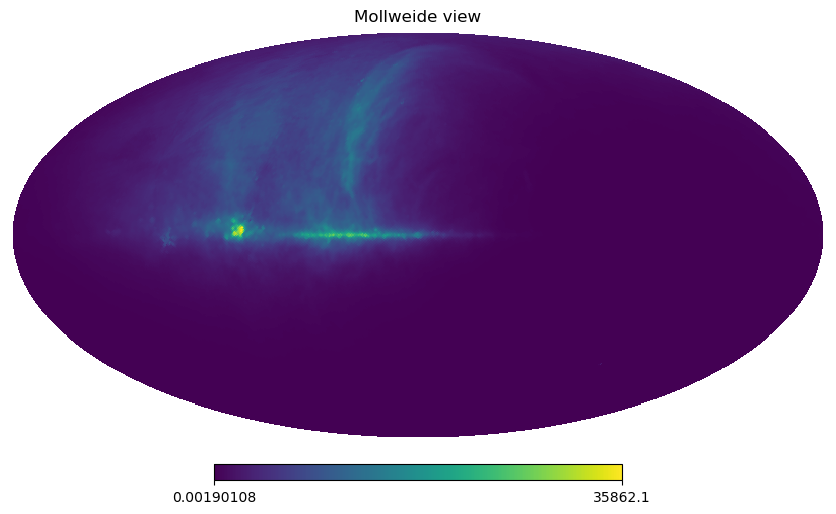

In [104]:
hp.mollview(testing[1][9])

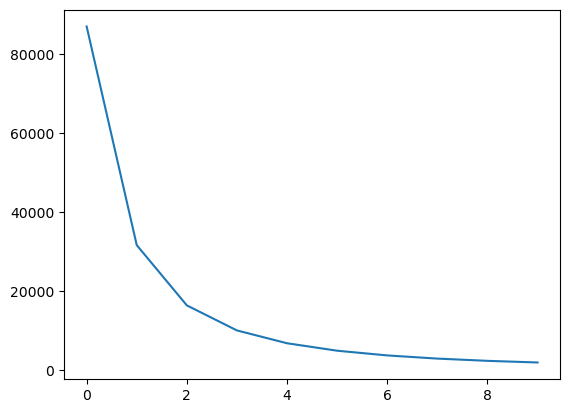

In [105]:
plt.plot(testing[3])

### This is the start of the "Stuff that didn't work / troubleshooting appendix"

All healpy routines assume RING ordering, in fact as soon as you read a map with read_map, even if it was stored as NESTED, it is transformed to RING. However, you can work in NESTED ordering passing the nest=True argument to most healpy routines.

In [16]:
### Stuff that didn't work for the Using the perses.beam.BaseGaussianBeam._GaussianBeam cell ###
# Let's play around with perses.beam.BaseGaussianBeam.GaussianDistribution

# std_function = lambda x: x**2
# std_function_array=np.ones ((num_data_points,num_data_points))
#for i in np.range(0,num_data_points):
   # std_function_array[][]
# gaussian_beam = perses.beam.BaseGaussianBeam.GaussianDistribution(0,10)

# This didn't work because the gaussian profile doesn't separate out each frequency.  Does something odd and a bit nonsensical, actually. Made my own (see above) by canabalizing this one.
#beamarray=GaussianBeam.gaussian_profile(GaussianBeam, frequencies, thetas, phis)   # use this to create an array

In [17]:
# Now let's plot this as a function of theta
plt.plot(thetas,beamarray)

# but what about the frequency dependence?



NameError: name 'beamarray' is not defined

In [ ]:
# Let's see if we can understand why there is no frequency dependence with this function:
exponent = thetas * np.ones_like(phis)
fwhms = np.vectorize(GaussianBeam.fwhm)(frequencies)
exponent = exponent / np.radians(fwhms)
exponent = exponent ** 2
profile = np.exp(-np.log(16) * exponent)

# According to this, the single gaussian profile you get is a bit nonsensical.  It's a gaussian profile evaluated at each angular value, but each angular value has a corresponding, different sigma.
# I see what's attempting to be done here but I also see that it's not working right.  I'm thinking its something to do with vectorize not doing now what it used to do when this was written maybe?
# Just going to right my own beam function canibalizing this one.  Let's see if that's worth the time:

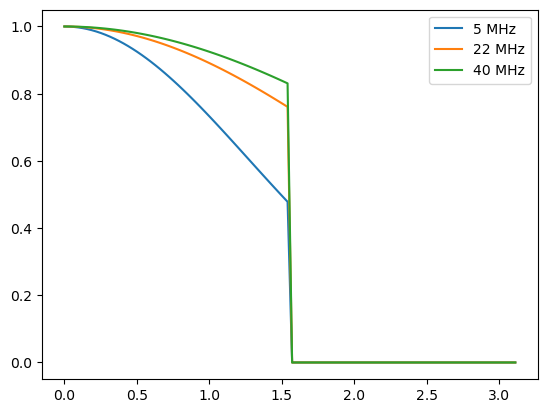

In [ ]:
#Plots three different frequency's gaussian profile
plt.plot(thetas,profile[0], label=f'{frequencies[0]*1e-6:.0f} MHz')
plt.plot(thetas,profile[49], label=f'{frequencies[49]*1e-6:.0f} MHz')
plt.plot(thetas,profile[99], label=f'{frequencies[99]*1e-6:.0f} MHz')
plt.legend()

In [ ]:
import ares

In [ ]:
import ares.simulations


ares.simulations.Global21cm?

Init signature: ares.simulations.Global21cm(**kwargs)
Docstring:     
This class must be inherited by another class, which need only have the
``pf`` attribute.

The three most (only) important parameters are:
    blob_names
    blob_ivars
    blob_funcs
    
Init docstring:
Set up a two-zone model for the global 21-cm signal.

..note :: This is essentially a MultiPhaseMedium calculation, except
    the Lyman alpha background and 21-cm background are calculated,
    and alternative (phenomenological) parameterizations such as a
    tanh for the ionization, thermal, and LW background evolution,
    may be used.
File:           ~/ares/ares/simulations/Global21cm.py
Type:           type
Subclasses:     